In [45]:
import tensorflow as tf

from keras import backend as K

from keras.preprocessing.image import load_img

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras import optimizers

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import numpy as np

import pandas as pd

import os

In [2]:
import types
import matplotlib
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
            try:
                yield val.__version__
            except:
                pass
list(imports())

['builtins',
 'builtins',
 'tensorflow',
 '1.13.1',
 'keras.backend',
 'tensorflow.python.keras.optimizers',
 'matplotlib.pyplot',
 'matplotlib.image',
 'numpy',
 '1.13.3',
 'pandas',
 '0.25.2',
 'os',
 'types',
 'matplotlib',
 '3.1.1']

In [3]:
# Fixed for our Hot Dog & Pizza classes
NUM_CLASSES = 8

# Classification type
CLASSIFICATION_TYPE = 'categorical'

# Fixed for Hot Dog & Pizza color images
CHANNELS = 3

# AlexNet specific input image size
IMAGE_RESIZE = 227

# Padding strategy to keep the same image size
SAME_PADDING = 'same'

# Padding strategy with right and bottom crop
VALID_PADDING = 'valid'

# Pooling strategy
RESNET50_POOLING_AVERAGE = 'avg'

# Activation functions
CONVOLUTIONAL_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'softmax'

# Used to evaluate the error
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 3
EARLY_STOP_PATIENCE = 2

# Batch sizes for training and validation
BATCH_SIZE_TRAINING = 128
BATCH_SIZE_VALIDATION = 64

# Generate images
GENERATION_RATIO = 1
TOTAL_TRAIN_IMAGES = 6400

TOTAL_TEST_IMAGES = 1250

# Steps for each epoch
STEPS_PER_EPOCH_TRAINING = TOTAL_TRAIN_IMAGES / BATCH_SIZE_TRAINING
STEPS_PER_EPOCH_VALIDATION = TOTAL_TEST_IMAGES / BATCH_SIZE_VALIDATION

# Using 1 to easily manage mapping between test_generator & prediction
BATCH_SIZE_TESTING = 1

# Work directory to save the checkpoints
WORK_FOLDER = 'working'

# Checkpoint file name
CHECKPOINT_FILE = 'best.hdf5'

# Automatic save and replace mode of the weights
MODEL_CHECKPOINT_MODE = 'auto'

# The metrics that we want to monitor
LOSS_MONITOR = 'val_loss'

# Weights file name
WEIGHTS_FILE = 'best_weights.h5'

# The name of the .h5 file containing the pretrained weights for the ResNet50
WEIGHTS_FILE = 'resnet50_weights_notop.h5'

In [4]:
# Base folder path for the Hot Dog & Pizza classification images
BASE_FOLDER_PATH = 'kvasir-dataset-v2'

# The path to the training images
TRAIN_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'train')

# The path to the validation images
VALIDATION_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'valid')

# The path to the test images
TEST_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'test')

# Checkpoint file path
CHECKPOINT_FILE_PATH = os.path.join(WORK_FOLDER, CHECKPOINT_FILE)

# Weights file path
WEIGHTS_FILE_PATH = os.path.join(WORK_FOLDER, WEIGHTS_FILE)

# Generated train image paths
GENERATED_IMAGE_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'generated')

In [5]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(IMAGE_RESIZE, IMAGE_RESIZE)))

def read_images(image_path):
    image_names = os.listdir(image_path)
    image_paths = [os.path.join(image_path, image_name) for image_name in image_names]
    images = np.array([read(image_path) for image_path in image_paths], dtype='uint8')
    return images

In [6]:
class_names = {0: "dyed-lifted-polyps", 1: "dyed-resection-margins", 2: "esophagitis", 3: "normal-cecum",
               4: "normal-pylorus", 5: "normal-z-line", 6: "polyps", 7: "ulcerative-colitis"}

In [7]:
def predict_class(model, image):
    scaled_image = image/255.
    y_pred = model.predict_classes([[scaled_image]])
    confidence = model.predict([[scaled_image]])
    print("Predicted class:")
    
    print(class_names[y_pred[0]])
    
    print("Confidence:")
    print(confidence[0][0])

In [8]:
def plot_training_history(fit_history):
    training_accuracy_key = 'acc'
    training_loss_key = 'loss'
    
    test_accuracy_key = 'val_acc'
    test_loss_key = 'val_loss'
    
    diagrams_x_label = 'epoch'
    
    accuracy_diagram_title = 'model accuracy'
    accuracy_diagram_y_label = 'accuracy'
    
    loss_diagram_title = 'model loss'
    loss_diagram_y_label = 'loss'
    
    legend_labels = ['train', 'test']
    legend_position = 'upper left'
    
    # list all data in history
    print(fit_history.history.keys())
    
    # summarize history for accuracy
    plt.plot(fit_history.history[training_accuracy_key])
    plt.plot(fit_history.history[test_accuracy_key])
    plt.title(accuracy_diagram_title)
    plt.ylabel(accuracy_diagram_y_label)
    plt.xlabel(diagrams_x_label)
    plt.legend(legend_labels, loc=legend_position)
    plt.show()
    
    # summarize history for loss
    plt.plot(fit_history.history[training_loss_key])
    plt.plot(fit_history.history[test_loss_key])
    plt.title(loss_diagram_title)
    plt.ylabel(loss_diagram_y_label)
    plt.xlabel(diagrams_x_label)
    plt.legend(legend_labels, loc=legend_position)
    plt.show()

In [9]:
def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img)

In [53]:
lifted_polyps = os.path.join(TRAIN_FOLDER_PATH, class_names[1])

In [54]:
lifted_polyps_images = read_images(lifted_polyps)

In [55]:
lifted_polyps_images[0].shape

(227, 227, 3)

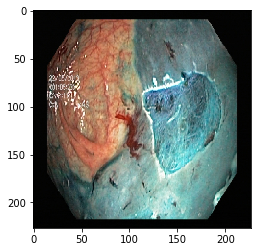

In [56]:
plt.imshow(lifted_polyps_images[45])

In [10]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = WEIGHTS_FILE))

model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 23,604,104
Trainable params: 16,392
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [13]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode=CLASSIFICATION_TYPE)

validation_generator = data_generator.flow_from_directory(
        TEST_FOLDER_PATH,
        target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode=CLASSIFICATION_TYPE)

Found 6400 images belonging to 8 classes.
Found 1250 images belonging to 8 classes.


In [14]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(128, 50, 64, 20)

In [15]:
cb_early_stopper = EarlyStopping(monitor = LOSS_MONITOR, patience = EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(filepath = CHECKPOINT_FILE_PATH, monitor = LOSS_MONITOR, save_best_only = True, mode = MODEL_CHECKPOINT_MODE)

learning_rate_reduction = ReduceLROnPlateau(monitor=LOSS_MONITOR, 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [70]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper],
        verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
50/50 [==============================] - 1965s 39s/step - loss: 0.6968 - acc: 0.7486 - val_loss: 0.7452 - val_acc: 0.7160
Epoch 2/3
50/50 [==============================] - 1875s 37s/step - loss: 0.3301 - acc: 0.8755 - val_loss: 0.4791 - val_acc: 0.7992
Epoch 3/3
50/50 [==============================] - 1888s 38s/step - loss: 0.2866 - acc: 0.8964 - val_loss: 0.3557 - val_acc: 0.8584


In [16]:
model.load_weights(CHECKPOINT_FILE_PATH)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


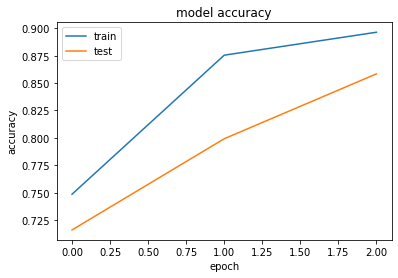

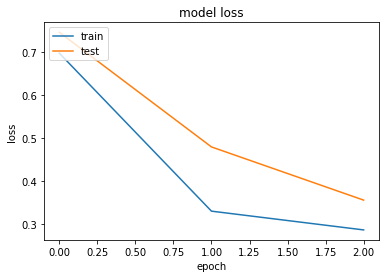

In [72]:
plot_training_history(fit_history)

In [17]:
test_generator = data_generator.flow_from_directory(
    directory = VALIDATION_FOLDER_PATH,
    target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 400 images belonging to 8 classes.


In [18]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

400/400 [==============================] - 122s 304ms/step


In [19]:
predicted_class_indices

array([0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 7, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 1, 0, 0, 0, 0, 6,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5,
       5, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 5, 6, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       2, 5, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       2, 5, 5, 5, 5, 5, 5, 2, 5, 5, 2, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 2,
       2, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5,
       5, 6,

In [20]:
labels = [class_names[predicted_class_indices[i]] for i in range(len(predicted_class_indices))]

In [21]:
labels

['dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-resection-margins',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'ulcerative-colitis',
 'dyed-lifted-polyps',
 'dyed-resection-margins',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'polyps',
 'polyps',
 'dyed-lifted-polyps',
 'dyed-resection-margins',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifte

In [26]:
def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img, interpolation='nearest')

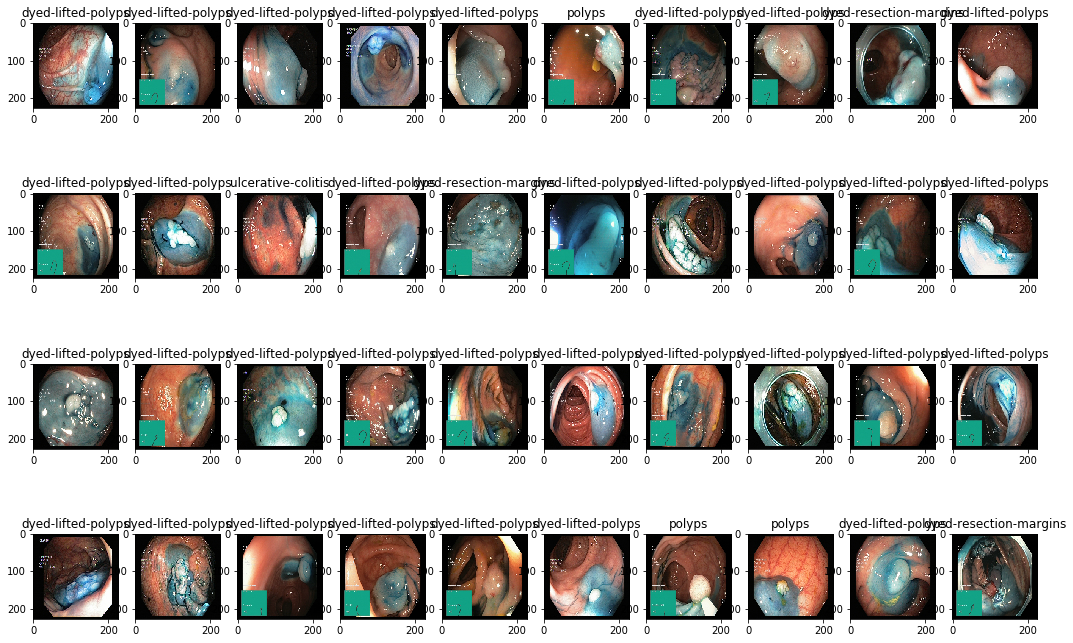

In [27]:
plot_image(VALIDATION_FOLDER_PATH, test_generator.filenames[0:41], 40, labels[0:61])

In [28]:
for file in test_generator.filenames[0:61]:
    print(file)

dyed-lifted-polyps\e05779e5-50c8-4340-886c-72e46782ce79.jpg
dyed-lifted-polyps\e1412a6f-494d-4b00-888b-31e66570725b.jpg
dyed-lifted-polyps\e3697c81-c770-4539-bc74-638522866c33.jpg
dyed-lifted-polyps\e652ff3d-ca91-4c7a-834d-9709cb3fb653.jpg
dyed-lifted-polyps\eb34cf1c-c209-4bf4-a8a4-40355e1682a7.jpg
dyed-lifted-polyps\eb437941-4daa-47e8-b249-fa5e181938a2.jpg
dyed-lifted-polyps\ebbc4f73-9f2b-4c8b-8b68-3f8d7b1a61ca.jpg
dyed-lifted-polyps\ecabcc8b-bf8e-4856-b969-27c2fe9b7fdb.jpg
dyed-lifted-polyps\ede60e54-62b9-415f-88d0-c7629204a535.jpg
dyed-lifted-polyps\ee6fdb33-2d7e-4e6e-b0ca-db7ac9e17c5b.jpg
dyed-lifted-polyps\ee8e60fd-b1b3-478b-9de0-d6d858c979e2.jpg
dyed-lifted-polyps\ee9f2ec2-a37f-48dd-996a-ede5bf68d3b1.jpg
dyed-lifted-polyps\eebbe5e6-eaaa-472b-b275-fbe1b9303afa.jpg
dyed-lifted-polyps\eede44ce-1540-4851-ae95-ea36954e2ad5.jpg
dyed-lifted-polyps\eee3b548-49fe-47f6-b12e-17045e9144e1.jpg
dyed-lifted-polyps\ef09f508-05c8-4cb1-b8d1-261d5b2826b4.jpg
dyed-lifted-polyps\ef1d6949-00f1-4813-ac

In [29]:
actual_class_names = [file_name.split("\\")[0] for file_name in test_generator.filenames]

In [30]:
actual_class_names

['dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lifted-polyps',
 'dyed-lift

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_class_names, labels)

In [39]:
cm

array([[42,  3,  0,  0,  0,  0,  4,  1],
       [ 9, 41,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 39,  0,  2,  8,  1,  0],
       [ 0,  0,  0, 48,  0,  0,  2,  0],
       [ 0,  0,  0,  0, 50,  0,  0,  0],
       [ 0,  0,  9,  0,  0, 41,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 50,  0],
       [ 0,  0,  0,  3,  1,  0,  0, 46]])

In [57]:
from sklearn.multiclass import OneVsRestClassifier

In [58]:
actual_class_values = [list(class_names.keys())[list(class_names.values()).index(value)] for value in actual_class_names]

In [64]:
actual_class_values

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [66]:
pred.shape

(400, 8)

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [83]:
accuracy_score(actual_class_names, labels)

0.89249999999999996

In [85]:
precision_score(actual_class_names, labels, average = 'micro')

0.89249999999999996

In [90]:
recall_score(actual_class_names, labels, average = 'micro')

0.89249999999999996

In [91]:
f1_score(actual_class_names, labels, average = 'micro')

0.89249999999999996

In [93]:
cohen_kappa_score(actual_class_names, labels)

0.87714285714285711